# Symbolic DAG Search - Tutorial

This tutorial is meant to get you familiar with the usage of this module.

Basically, we are looking for computational DAG that has the lowest loss for a given input.

Let $X\in \mathbb{R}^{N\times m}$ be an input matrix of $N$ samples with dimension $m$.\
Let further $U = \{f : \mathbb{R}^m\rightarrow \mathbb{R}^n\}$ be the set of all functions that map $m$-dimensional input to $n$-dimensional output.
Then we are looking for 

\begin{align*}
\text{argmin}_{f\in U}L(f_X)\,,
\end{align*}

that is the function that minimizes a loss function $L$ on the function $f$ at the samples $X$.

As we shall see later, this is not restricted to regression tasks and can involve any loss that depends on function values or gradients of the function at the input samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DAG_search import dag_search
from DAG_search import comp_graph

## Simple Regression

The most basic use case is Regression, where we want the function values to fit to some given values. That is we are looking for 

\begin{align}
\text{argmin}_{f}\cfrac{1}{N}\sum_{i=1}^N\left(f(X_i) - y_i\right)^2
\end{align}

For simple 1D Problems, we can use the scikit-learn Interface.

Note: Following the convention of sklearn regressors, $y$ has to be a 1D vector here.

**Example**:

Symbolic Regression for the function

\begin{align}
f(x) = \sin(x_0^2) + x_1
\end{align}

In [2]:
# define regression problem
np.random.seed(0)
X = np.random.rand(100, 2)
y = np.sin(X[:, 0]**2) + X[:, 1]

# use regressor
est = dag_search.DAGRegressor(n_calc_nodes = 2, max_orders = int(1e4))
est.fit(X, y, verbose = 2)

Creating evaluation orders


100%|██████████████████████████████████████████████████████████████████████████| 7200/7200 [00:00<00:00, 299509.95it/s]


Total orders: 405
Evaluating orders


 22%|██████████████▊                                                     | 88/405 [00:12<00:45,  6.98it/s, best_loss=0]

Optimizing best constants
Found graph with loss 0.0


DAGRegressor(max_orders=10000, n_calc_nodes=2, positives=array([ True,  True]))

In [3]:
# get symbolic expression
est.model()

x_1 + sin(x_0**2)

or numerically

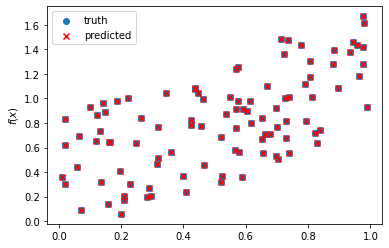

In [4]:
# predict
pred = est.predict(X)


# plotting
plt.scatter(X[:, 0], y, label = 'truth')
plt.scatter(X[:, 0], pred, marker = 'x', color = 'red', label = 'predicted')
plt.legend()
plt.ylabel(f'$f(x)$')
plt.show()

## Multidimensional Regression

In the case of $y\in\mathbb{R}^n$ being multidimensional one can either

1. treat it as $n$ seperate regression problems. This has the advantage of the search space staying small.
2. use a multidimensional loss function. This formulation can make use of shared subexpressions between the outputs.
\begin{align}
\text{argmin}_{f}\cfrac{1}{Nn}\sum_{j=1}^n\sum_{i=1}^N\left(f(X_i)_j - y_{ij}\right)^2
\end{align}

In case of 1. refer to the example above or use the following example with $n=1$. In case of 2. we support two different methods:

1. **Exhaustive search**: Builds up function skeletons and then tests each assignment of operators to each skeleton.
2. **Sample search**: Randomly samples functions and evaluates them.

Both methods return their solutions in the form of computational DAGs

**Example**: 

Symbolic Regression for the function

\begin{align}
f(x) = \begin{bmatrix}
0.5x\\
-x
\end{bmatrix}
\end{align}

In [5]:
# Problem definition
X = np.random.rand(100, 1)
c = 0.5
y = np.column_stack([c*X[:,0], -X[:,0]])

### Exhaustive Search

In [6]:
# define loss function
loss_fkt = dag_search.MSE_loss_fkt(y)

# search
params = {
    'X' : X,
    'n_outps' : y.shape[1],
    'loss_fkt' : loss_fkt,
    'k' : 1,
    'n_calc_nodes' : 1,
    'n_processes' : 1,
    'topk' : 5,
    'opt_mode' : 'grid_zoom',
    'verbose' : 2,
    'max_orders' : 10000, 
    'stop_thresh' : 1e-4,
    'max_time' : 3600.0
}

res = dag_search.exhaustive_search(**params)

Creating evaluation orders


100%|████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 180931.58it/s]


Total orders: 305
Evaluating orders


  6%|████▏                                                               | 19/305 [00:04<01:01,  4.61it/s, best_loss=0]


Lets view the solutions found.

The result is a dictionary containing the top-k solutions that were encountered.

Each solution consists of a `graph` and its `constants`.

Loss: 0.0


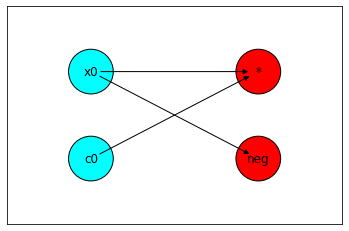

In [7]:
idx = 0 # solution number
graph = res['graphs'][idx]
consts = res['consts'][idx]
loss = res['losses'][idx]
print(f'Loss: {loss}')

comp_graph.plot_cgraph(graph, ax = plt.gca())

The graph can be evaluated symbolically and will return a list of symbolic expressions (one for each output dimension):

In [8]:
exprs = graph.evaluate_symbolic(c = consts)
for expr in exprs:
    print(expr)

0.5*x_0
-x_0


Or it can be evaluated numerically for prediction:

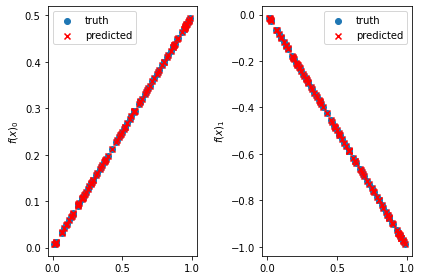

In [9]:
# predict
pred = graph.evaluate(X, c = consts)


# plotting
fig, axs = plt.subplots(ncols = y.shape[1])
for i in range(y.shape[1]):
    axs[i].scatter(X[:, 0], y[:, i], label = 'truth')
    axs[i].scatter(X[:, 0], pred[:, i], marker = 'x', color = 'red', label = 'predicted')
    axs[i].legend()
    axs[i].set_ylabel(f'$f(x)_{i}$')
plt.tight_layout()
plt.show()

### Sample Search

Lets go trough the same pipeline for the sampling search:

In [10]:
# define loss function
loss_fkt = dag_search.MSE_loss_fkt(y)

params = {
    'X' : X,
    'n_outps' : y.shape[1],
    'loss_fkt' : loss_fkt,
    'k' : 1,
    'n_calc_nodes' : 5,
    'n_processes' : 1,
    'topk' : 5,
    'opt_mode' : 'grid_zoom',
    'verbose' : 2,
    'n_samples' : 10000,
    'stop_thresh' : 1e-4
    
}
res = dag_search.sample_search(**params)

Generating graphs


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 638.84it/s]


Evaluating graphs


 11%|███████                                                        | 1112/10000 [00:03<00:25, 349.86it/s, best_loss=0]


Select a solution:

Loss: 0.0


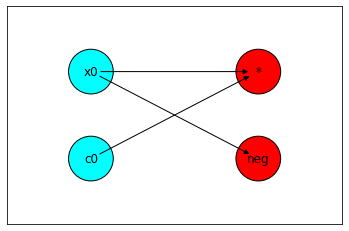

In [11]:
idx = 0 # solution number
graph = res['graphs'][idx]
consts = res['consts'][idx]
loss = res['losses'][idx]
print(f'Loss: {loss}')

comp_graph.plot_cgraph(graph, ax = plt.gca())

And evaluate it symbolically

In [12]:
exprs = graph.evaluate_symbolic(c = consts)
for expr in exprs:
    print(expr)

0.5*x_0
-x_0


Or numerically

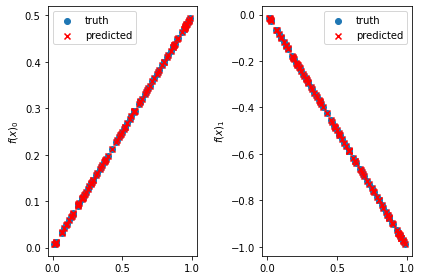

In [13]:
# predict
pred = graph.evaluate(X, c = consts)


# plotting
fig, axs = plt.subplots(ncols = y.shape[1])
for i in range(y.shape[1]):
    axs[i].scatter(X[:, 0], y[:, i], label = 'truth')
    axs[i].scatter(X[:, 0], pred[:, i], marker = 'x', color = 'red', label = 'predicted')
    axs[i].legend()
    axs[i].set_ylabel(f'$f(x)_{i}$')
plt.tight_layout()
plt.show()

## Custom Loss Function - Classification

The DAG search is not restricted to Regression tasks. In fact we can define **any loss function that depends on the function- or the gradient values**.\
The only restriction is that the target minimum has to be 0.

Lets consider the problem of finding a classification function.

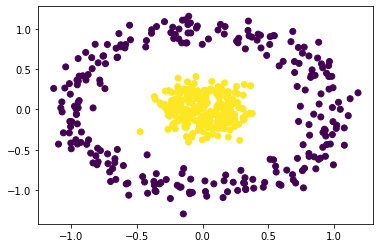

In [14]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=500, noise=0.1, factor=0.2, random_state=1)
plt.scatter(X[:, 0], X[:, 1], c = y)

Our goal is to find a function $f$, such that we can classify using
\begin{align}
\kappa(x_0, x_1) = \begin{cases}
1&\text{, if }f(x_1, x_0) < 0\\
0&\text{, if }f(x_1, x_0) \geq 0\\
\end{cases}
\end{align}

We can formulate this as an optimization problem with a loss function
\begin{align}
L(f) &= 1 - \cfrac{1}{N}\mathbb{1}[\kappa(X_i) = y_i]\,,
\end{align}
where we simply calculate 1 minus the accuracy if we take $f$ for classification.

To define our custom loss function, we should inherit from `dag_search.DAG_Loss_fkt`.
See the example below.

Note that we evaluate for multiple constants simultaneously (parameter `r`).

In [15]:
from DAG_search import comp_graph
import warnings

class Class_loss_fkt(dag_search.DAG_Loss_fkt):
    def __init__(self, y):
        '''
        Loss function for finding DAG for regression task.

        @Params:
            Here you can add any parameters that Loss function depends on.
        '''
        
        # in our case, the loss function depends on the true class labels
        super().__init__()
        self.y = y
        
        
    def __call__(self, X:np.ndarray, cgraph:comp_graph.CompGraph, c:np.ndarray) -> np.ndarray:
        '''
        Lossfkt(X, graph, consts)

        @Params:
            X... input for DAG (N x m)
            cgraph... computational Graph
            c... array of constants (2D)

        @Returns:
            Loss for different constants
        '''
        if len(c.shape) == 2:
            r = c.shape[0]
            vec = True
        else:
            r = 1
            c = c.reshape(1, -1)
            vec = False

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            pred = cgraph.evaluate(X, c = c)
            # pred : shape r x N x outp_dim
            
            preds = (pred[:, :, 0] < 0).astype(int) # shape r x N
            accuracy = np.mean(preds == self.y, axis = -1) # shape r
            losses = 1 - accuracy
            
            # must not be nan or inf
            invalid = ~np.isfinite(losses)
            
        # consider not using inf, since optimizers struggle with this
        losses[invalid] = 1000
        losses[losses > 1000] = 1000

        if not vec:
            return losses[0]
        else:
            return losses

Next we can simply start the search process with our new loss function:

In [16]:
np.random.seed(0)

# define loss function
loss_fkt = Class_loss_fkt(y)

# search
params = {
    'X' : X,
    'n_outps' : 1,
    'loss_fkt' : loss_fkt,
    'k' : 1,
    'n_calc_nodes' : 3,
    'n_processes' : 1,
    'topk' : 1,
    'opt_mode' : 'grid_zoom',
    'verbose' : 2,
    'max_orders' : 5000, 
    'stop_thresh' : 1e-20
}

res = dag_search.exhaustive_search(**params)

Creating evaluation orders


  2%|█▏                                                                      | 5000/302400 [00:00<00:02, 119085.32it/s]


Total orders: 351
Evaluating orders


 85%|█████████████████████████████████████████████████████████          | 299/351 [05:40<00:59,  1.14s/it, best_loss=0]


And we get the following expression:

In [17]:
idx = 0
graph = res['graphs'][idx]
consts = res['consts'][idx]
graph.evaluate_symbolic(c = consts)[0]

x_0**2 + x_1**2 - 0.4965525216

Which classifies as follows:

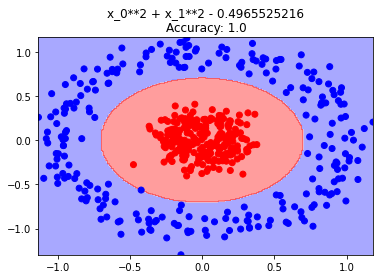

In [18]:
pred = (graph.evaluate(X, c = consts)[:, 0] < 0).astype(int)
expr = str(graph.evaluate_symbolic(c = consts)[0])
plt.title(f'{expr}\nAccuracy: {np.mean(pred == y)}')

# plot decision boundary

dx, dy = 0.01, 0.01
# generate grids + labels
x1, x2 = np.mgrid[
    slice(np.min(X[:, -2]), np.max(X[:, -2]) + dy, dy),
    slice(np.min(X[:, -1]), np.max(X[:, -1]) + dx, dx),
]
points = np.stack([x1.flatten(), x2.flatten()]).T
labels = (graph.evaluate(points, c = consts)[:, 0] < 0).astype(int)
labels = labels.reshape(x1.shape)

# plot points + areas
cmap = plt.get_cmap("bwr")
plt.gca().contourf(
    x1,
    x2,
    labels,
    cmap=cmap,
    alpha=0.4,
    vmin=0,
    vmax=1
)
#plt.colorbar()
plt.scatter(X[:, -2], X[:, -1], c=y, cmap="bwr")

## Custom Loss Function - Solving ODEs

The computational DAG class can also use the [PyTorch](https://pytorch.org/) autodiff engine.
This allows the formulation of Loss functions that depend on the gradient of the expression.

Lets go trough an example by solving an **O**rdinary **D**ifferential **E**quation (ODE):

For a given function $f(t, y)$, we are looking for a function $y(t)$ with $y'(t) = f(t, y)$.

Let for example 
\begin{align}
f(t, y) = 0.25y
\end{align}

In [19]:
def ode(t, y):
    # t... shape N x 1
    # y... shape r x N x d
    # result... shape r x N x d
    return 0.25*y

We can formulate the loss function as the MSE between $f(t, y)$ and $y'$.

Note how we use the `return_grad` keyword to get $y'$.

In [20]:
from DAG_search import comp_graph
import warnings

class ODE_loss_fkt(dag_search.DAG_Loss_fkt):
    def __init__(self, ode_func):
        '''
        Loss function for finding DAG for regression task.

        @Params:
            Here you can add any parameters that Loss function depends on.
        '''
        
        # in our case, the loss function depends on the true class labels
        super().__init__()
        self.ode_func = ode_func
        
        
    def __call__(self, X:np.ndarray, cgraph:comp_graph.CompGraph, c:np.ndarray) -> np.ndarray:
        '''
        Lossfkt(X, graph, consts)

        @Params:
            X... time series (N x 1)
            cgraph... computational Graph
            c... array of constants (2D)

        @Returns:
            Loss for different constants
        '''
        t = X
        if len(c.shape) == 2:
            r = c.shape[0]
            vec = True
        else:
            r = 1
            c = c.reshape(1, -1)
            vec = False

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y, y_ = cgraph.evaluate(t, c = c, return_grad = True)
            # y : shape r x N x d
            # y' : shape r x d x N x 1
            
            
            term1 = self.ode_func(t, y).reshape(r, -1)
            term2 = np.transpose(y_[:, :, :, 0], (0, 2, 1)).reshape(r, -1)
            losses = np.mean((term1 - term2)**2, axis = -1)
            
            # sort out constant functions
            tmp = np.var(y_[:, :, :, 0], axis= -1) # r x d
            mask = np.all(tmp  <= 1e-5, axis = -1) # r 
            losses[mask] = 1000
            
            mask = np.any(np.abs(y.reshape(r, -1)) > 1e10, axis = -1)
            losses[mask] = 1000
            
              
            # must not be nan or inf
            invalid = ~np.isfinite(losses)
            
        # consider not using inf, since optimizers struggle with this
        losses[invalid] = 1000
        losses[losses > 1000] = 1000

        if not vec:
            return losses[0]
        else:
            return losses

And now we have everything to start the search.

In [21]:
np.random.seed(0)

# define loss function
t = np.linspace(1, 10, 100).reshape(-1, 1)
loss_fkt = ODE_loss_fkt(ode)

# search
params = {
    'X' : t,
    'n_outps' : 1,
    'loss_fkt' : loss_fkt,
    'k' : 1,
    'n_calc_nodes' : 2,
    'n_processes' : 1,
    'topk' : 5,
    'opt_mode' : 'grid_zoom',
    'verbose' : 2,
    'max_orders' : 10000, 
    'stop_thresh' : 1e-30
}

res = dag_search.exhaustive_search(**params)

Creating evaluation orders


100%|██████████████████████████████████████████████████████████████████████████| 1440/1440 [00:00<00:00, 239874.41it/s]


Total orders: 150
Evaluating orders


 13%|████████▌                                                           | 19/150 [00:04<00:31,  4.10it/s, best_loss=0]


Lets see what we got:

In [22]:
graph, consts = res['graphs'][0], res['consts'][0]
graph.evaluate_symbolic(c = consts)[0]

exp(0.25*x_0)

Indeed, if $y(t) = e^{0.25t}$, we have that
\begin{align}
f(t, y) &= 0.25y\\
&= 0.25e^{0.25t}\\
&= y'(t)
\end{align}